In [1]:
import cv2 
import pandas as pd 
import numpy as np 
from glob import glob 
import os  

import random 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split 
import albumentations as album
from datetime import datetime

import segmentation_models_pytorch  
import segmentation_models_pytorch as smp
import torch 
import torch as th 
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
TRAINING = True
EPOCHS = 10
BATCH_SIZE = 8
print(DEVICE)
DATA_NAME = 'Sign_dataset'
mount_path = "/home/azureuser/cloudfiles/code/Users/samarth.tandon/sign_matching/data/"

Extension horovod.torch has not been built: /anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/horovod/torch/mpi_lib_v2.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.
cuda


In [2]:
DATA_DIR = os.path.join(mount_path,"train_data/train_dataset_road_geometry/")

IMAGE_DIR = glob(os.path.join(DATA_DIR,'rgb_image')+'/*.png')
ROAD_MASK = glob(os.path.join(DATA_DIR,'roads_mask')+'/*.png')
PROBE_MASK = glob(os.path.join(DATA_DIR,'probe_data')+'/*.png')
DTRF_MASK = glob(os.path.join(DATA_DIR,'no_entry_mask') +'/*.png')

GT_MASK = glob(os.path.join(DATA_DIR,'gt_mask')+'/*.png')

print(f"RGB images {len(IMAGE_DIR)}\n ROAD MASK images {len(ROAD_MASK)}\n GPS probe images {len(PROBE_MASK)}\n DTRF images {len(DTRF_MASK)}\n" )
print("Ground Truth Images ",len(GT_MASK))

RGB images 1963
 ROAD MASK images 1963
 GPS probe images 1963
 DTRF images 2000

Ground Truth Images  1165


### Split Dataset into Train and Validation 

In [3]:
mask_images = np.asarray(GT_MASK)
print("GT images :",len(mask_images))

y_train , y_test = train_test_split(mask_images,train_size=0.95,test_size=0.05,random_state=23)
print("train Data ",y_train.shape,"Test data ",y_test.shape)

GT images : 1165
train Data  (1106,) Test data  (59,)


In [4]:
image_path = [image_id.replace('gt_mask','rgb_image') for image_id in y_train]
road_path = [image_id.replace('gt_mask','roads_mask') for image_id in y_train]
probe_path = [image_id.replace('gt_mask','probe_data') for image_id in y_train]
sign_path = [image_id.replace('gt_mask','no_entry_mask') for image_id in y_train]

train_images = np.asarray([(rgb,probe,road,sign) for rgb,probe,road,sign in zip(image_path,probe_path,road_path,sign_path)])

image_test = [image_id.replace('gt_mask','rgb_image') for image_id in y_test]
road_test = [image_id.replace('gt_mask','roads_mask') for image_id in y_test]
probe_test = [image_id.replace('gt_mask','probe_data') for image_id in y_test]
sign_test = [image_id.replace('gt_mask','no_entry_mask') for image_id in y_test]

test_images = np.asarray([(rgb,probe,road,sign) for rgb,probe,road,sign in zip(image_test,probe_test,road_test,sign_test)])

print("Train images :",train_images.shape)
print("Test Images :",test_images.shape)


Train images : (1106, 4)
Test Images : (59, 4)


In [5]:
# Get class names
class_names = ['background','no_entry_sign']
# Get class RGB values
class_rgb_values = [[0, 0, 0], [255, 255, 255]]
print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'no_entry_sign']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


<Figure size 2000x1000 with 0 Axes>

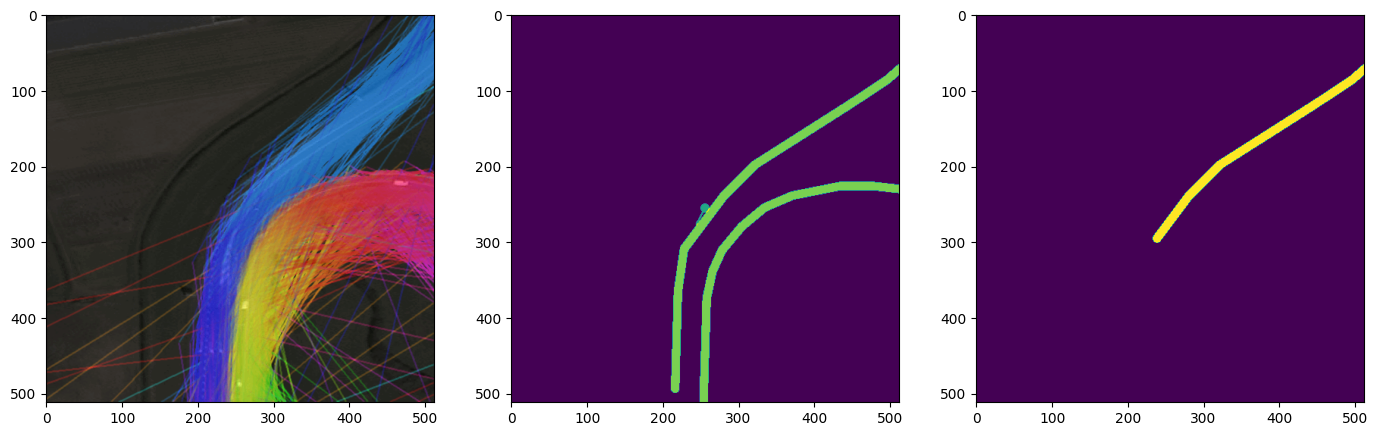

In [6]:
# helper function for data visualization
image_id = np.random.choice(GT_MASK, 1)[0]

plt.figure(figsize=(20,10))
alpha = 0.4 

def read_image_mask(path,mask=False):
    img = cv2.imread(path)
    if mask:
        return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


plt.figure(figsize=(17,19))
out_img = read_image_mask(image_id,mask=1)

in_rgb = read_image_mask(image_id.replace('gt_mask','rgb_image'))
in_probe = read_image_mask(image_id.replace('gt_mask','probe_data'))
overlay_image = cv2.addWeighted(in_rgb, alpha, in_probe, 1-alpha, 0)


in_road = read_image_mask(image_id.replace('gt_mask','roads_mask'),mask=1)
in_sign = read_image_mask(image_id.replace('gt_mask','no_entry_mask'),mask=1 )
overlay_mask = cv2.addWeighted(in_road, alpha*2, in_sign, 1-alpha, 0)


plt.subplot(1,3,1)
plt.imshow(overlay_image)

plt.subplot(1,3,2)
plt.imshow(overlay_mask)

plt.subplot(1,3,3)
plt.imshow(out_img)


In [7]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [8]:
def get_training_augmentation():
    train_transform = [    
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
                # album.OneOf([album.CLAHE(p=1),album.RandomBrightness(p=1),album.RandomGamma(p=1)],p=0.9)
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    if preprocessing_fn:
        _transform = [
            album.Lambda(image=preprocessing_fn),
            album.Lambda(image=to_tensor, mask=to_tensor),
        ]
    else:
        _transform = [
            album.Lambda(image=to_tensor,mask=to_tensor),
            # transforms.Normalize(mean, std)

        ]
    return album.Compose(_transform)

#### Dataset Creation

In [9]:
import itertools

class SignDataset(torch.utils.data.Dataset):
    def __init__(self, input_images_path, input_masks_path ,
                        class_rgb_values=None, 
                        augmentation=None, 
                        preprocessing=None,
                        image_width= 256, 
                        image_height=256,
                        rgb_channel = 0,
                        probe_channel = 0,
                        road_channel = 0
                        ):
        
        self.image_paths = input_images_path
        self.mask_paths = input_masks_path
        self.class_rgb_values = class_rgb_values

        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.height = image_height
        self.width = image_width 

        self.rgb_channel = rgb_channel
        self.probe_channel = probe_channel
        self.road_channel = road_channel

    def read_and_split_channels(self,path,mask=False):
        img = cv2.imread(path)
        if self.width!=512 and self.height !=512:
            img = cv2.resize(img,(self.width,self.height),interpolation=cv2.INTER_AREA)
        if mask:
            return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        else:
            r,g,b  = cv2.split(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            return r,g,b 

    def create_rgb_channel(self,rgb_image):
        r,g,b = self.read_and_split_channels(rgb_image,mask=False)
        return r,g,b

    def create_probe_channel(self,probe_image):
        pr,pg,pb = self.read_and_split_channels(probe_image)
        return pr,pg,pb 

    def create_combine_image(self,image_paths):
        rgb_image,probe_image,road_mask,sign_mask = image_paths
        mask_channels = list()
        r = g = b=  None 
        pr = pg = pb = None 
        road = None

        if self.rgb_channel:
            r,g,b = self.create_rgb_channel(rgb_image)            
            
        if self.probe_channel: 
            pr, pg, pb = self.create_probe_channel(probe_image)
        
        if self.road_channel :
            road = self.read_and_split_channels(road_mask,mask=True)
        
        sign = self.read_and_split_channels(sign_mask,mask=True)
            
        all_channels = [r,g,b,pr,pg,pb,road,sign]
        
        for channel in all_channels:
            if channel is not None:
                mask_channels.append(channel)

        combine_img = np.zeros([self.height,self.width,len(mask_channels)],dtype=np.uint8)
        
        for i in range(len(mask_channels)):
            combine_img[:,:,i] = mask_channels[i]
        
        return combine_img 

    def __getitem__(self, i):
        # read images and masks
        image = self.create_combine_image(self.image_paths[i]) # NxWxH (8x512x512)
        image = image.astype(np.float32)/255.0
        
        gt_mask = cv2.imread(self.mask_paths[i],cv2.COLOR_BGR2GRAY)
        if self.width!=512 and self.height !=512:
            gt_mask = cv2.resize(gt_mask,(self.width,self.height),interpolation=cv2.INTER_AREA)
        
        gt_mask = gt_mask/255.0
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=gt_mask)
            image, gt_mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            gt_mask = np.expand_dims(gt_mask,axis=-1)
            sample = self.preprocessing(image=image, mask=gt_mask)
            image, gt_mask = sample['image'], sample['mask']
        return image ,gt_mask 

    def __len__(self):
        # return length of images dataset 
        return self.image_paths.shape[0]

(256, 256, 5) (256, 256)


Text(0.5, 1.0, 'Heading mask')

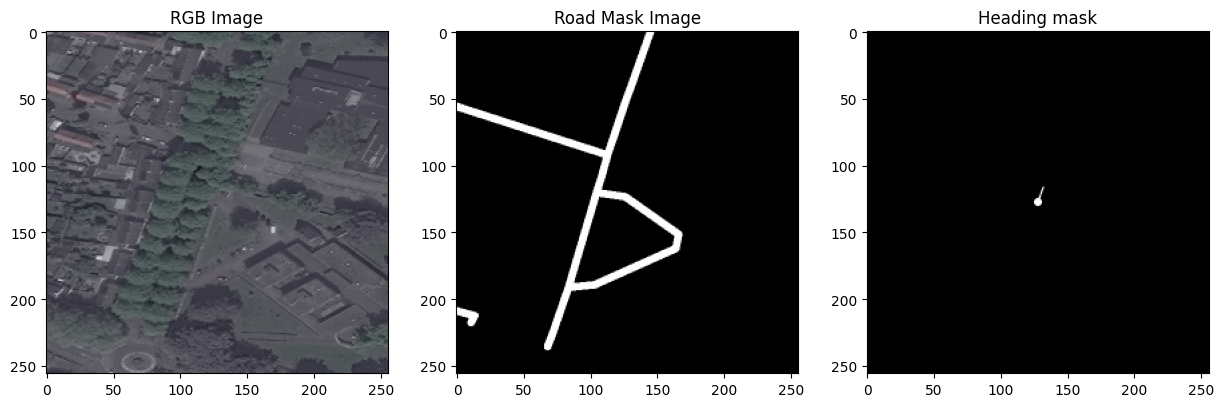

In [10]:
dataset = SignDataset(train_images, 
                        mask_images, 
                        class_rgb_values=class_rgb_values,
                        image_height=256,
                        image_width=256,
                        rgb_channel= 1,
                        road_channel= 1,
                        probe_channel= 0)

random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

print(image.shape ,mask.shape)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.title('RGB Image')
plt.imshow(image[:,:,0:3])

plt.subplot(1,3,2)
plt.title('Road Mask Image')
plt.imshow(image[:,:,3],cmap='gray')

# plt.subplot(1,5,3)
# plt.imshow(image[:,:,3],cmap='gray')
# plt.title('Probe mask')

plt.subplot(1,3,3)
plt.imshow(image[:,:,4],cmap='gray')
plt.title('Heading mask')

# plt.subplot(1,5,5)
# plt.imshow(mask,cmap='gray')
# plt.title('Ground Truth Road Element')

### Pre Processing and Augmentation on Dataset 

(256, 256, 5) (256, 256)


Text(0.5, 1.0, 'Heading mask')

<Figure size 1000x1500 with 0 Axes>

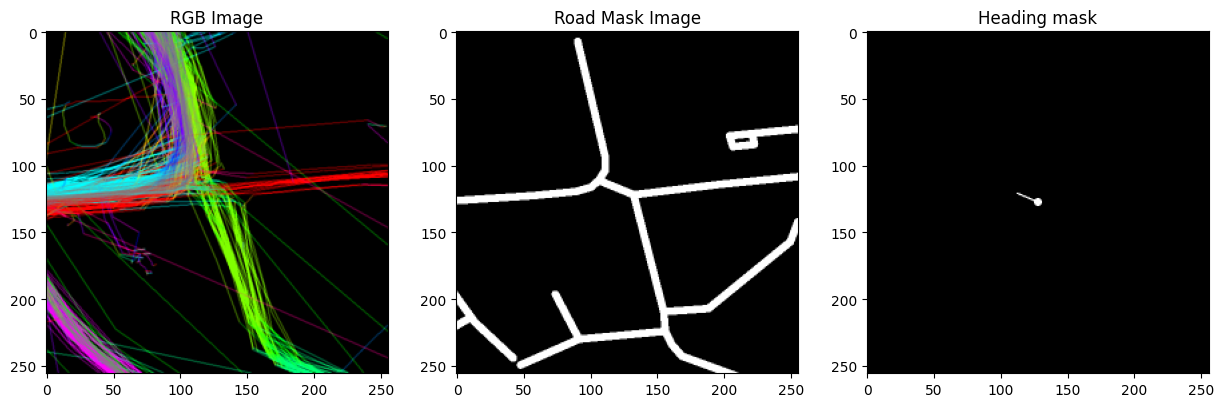

In [11]:
augmented_dataset = SignDataset(train_images, y_train, augmentation=get_training_augmentation(),
                            image_width=256, image_height=256, probe_channel=1, rgb_channel=0,road_channel=1)

random_idx = random.randint(0, len(augmented_dataset)-1)
count = 0
plt.figure(figsize=(10,15))

image, mask = augmented_dataset[random_idx]

print(image.shape ,mask.shape )

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.title('RGB Image')
plt.imshow(image[:,:,0:3])

plt.subplot(1,3,2)
plt.title('Road Mask Image')
plt.imshow(image[:,:,3],cmap='gray')

# plt.subplot(1,5,3)
# plt.imshow(image[:,:,3],cmap='gray')
# plt.title('Probe mask')

plt.subplot(1,3,3)
plt.imshow(image[:,:,4],cmap='gray')
plt.title('Heading mask')

### Build Pytorch UNET model 

In [12]:
ENCODER = 'mit_b0'
ENCODER_WEIGHTS = None
CLASSES = class_names
ACTIVATION = 'softmax' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
backbone_model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes= 1, 
    activation=ACTIVATION,
    in_channels = 3
)


## Create Train Loader 

In [13]:
# Add pre-processing function for Resnet 
if ENCODER_WEIGHTS=='imagenet':
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = SignDataset(train_images, y_train,
    augmentation= get_training_augmentation(),
    preprocessing= get_preprocessing(),
    image_width = 256,
    image_height = 256,
    rgb_channel=0,
    probe_channel= 1,
    road_channel=0

    )

test_dataset = SignDataset(test_images, y_test,
        augmentation= get_training_augmentation(),
        preprocessing= get_preprocessing(),
        image_width = 256,
        image_height = 256,
        rgb_channel= 0,
        probe_channel = 1,
        road_channel = 0
    )

image, mask = train_dataset[20]

print(image.shape ,mask.shape )

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=True,num_workers=1)

(4, 256, 256) (1, 256, 256)


## Define Metric/Losses/Optimizer 

In [14]:
# ALPHA = 0.9
# GAMMA = 2 

# class IoULoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(IoULoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #intersection is equivalent to True Positive count
#         #union is the mutually inclusive area of all labels & predictions 
#         intersection = (inputs * targets).sum()
#         total = (inputs + targets).sum()
#         union = total - intersection 
#         IoU = (intersection + smooth)/(union + smooth)
                
#         return 1 - IoU


# class FocalLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(FocalLoss, self).__init__()

#     def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #first compute binary cross-entropy 
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         BCE_EXP = torch.exp(-BCE)
#         focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
#         return focal_loss


In [15]:
import torch.nn.functional as F 
import segmentation_models_pytorch.utils as smp_utils
import segmentation_models_pytorch.utils.metrics as metrics  

# define loss function

loss1 = smp.losses.DiceLoss(mode='binary')
loss1.__name__='Dice_loss'

loss2 = smp.losses.FocalLoss(mode='binary')
loss2.__name__ = 'Focal_loss'

metrics = [metrics.IoU(threshold=0.5)]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=backbone_model.parameters(), lr=0.001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=1, T_mult=2, eta_min=5e-5,
# )

### Train Epoch  with Imagenet Weights 

In [16]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout,Sequential

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.cnn_block = nn.Sequential(
            nn.Conv2d(in_channels=4,out_channels=16,kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16,out_channels=3,kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
            
            # nn.BatchNorm2d(3),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=1,stride=1,padding=1)
        )
        self.unet = smp.Unet(
                encoder_name='mit_b1', 
                encoder_weights='imagenet', 
                classes= 1, 
                activation='sigmoid',
                in_channels = 3
                )

    def forward(self,x):
        x = self.cnn_block(x)
        return self.unet(x)


In [17]:

cnn_seg_transformer = CNNModel()

train_epoch = smp_utils.train.TrainEpoch(
    cnn_seg_transformer, 
    loss=loss2 ,
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,

)

valid_epoch = smp.utils.train.ValidEpoch(
    cnn_seg_transformer, 
    loss=loss2 ,
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b1.pth" to /home/azureuser/.cache/torch/hub/checkpoints/mit_b1.pth
100%|██████████| 52.2M/52.2M [00:01<00:00, 45.0MB/s]


In [ ]:
%%time
best_iou_score= 0.0
train_logs_list, valid_logs_list = [], []
for i in range(0,50):
    print('\nEpoch: {}'.format(i+1))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(test_loader)    
    # Save model if a better val IoU score is obtained
    if best_iou_score < valid_logs['iou_score']:
        best_iou_score = valid_logs['iou_score']
        torch.save(backbone_model, './model/best_seg_former_model_probe.pth')
        print('Model saved!') 

### Create a Test Image 

In [22]:
image_id = [image_id for image_id in GT_MASK if 'b270f986-f350-463b-8a38-bbc06ee5cd37.png' in os.path.basename(image_id)][0]
combine_img = np.zeros([512,512,5],dtype=np.uint8)

plt.figure(figsize=(7,9))
alpha = 0.4 

def read_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def read_and_split_channels(img,mask=False):
    if mask:
        return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        r,g,b  = cv2.split(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        return r,g,b 

gt_image = read_image(image_id)

in_rgb = read_image(image_id.replace('gt_mask','rgb_image'))
in_probe = read_image(image_id.replace('gt_mask','probe_data'))
overlay_sat_probe = cv2.addWeighted(in_rgb, alpha, in_probe, 0.1, 0)

in_road = read_image_mask(image_id.replace('gt_mask','roads_mask'))
in_sign = read_image_mask(image_id.replace('gt_mask','no_entry_mask'))

<Figure size 700x900 with 0 Axes>

In [24]:
# overlay_road_sign  = cv2.addWeighted(in_road, alpha, in_sign, 1-alpha, 0)
# overlay_road_sign_pred = cv2.addWeighted(overlay_road_sign,alpha,gt_image,1-alpha,0)

# final_image = cv2.addWeighted(overlay_sat_probe,0.7,overlay_road_sign_pred,0.6,0)
# plt.title("Aerial Image with Probe Data")
# plt.imshow(final_image)

r,g,b = read_and_split_channels(in_rgb,mask=False)
pr,pg,pb = read_and_split_channels(in_probe,mask=False)

road = read_and_split_channels(in_road,mask=True)
sign = read_and_split_channels(in_sign,mask=True)

# combine_img[:,:,0] = r/255.0
# combine_img[:,:,1] = g/255.0
# combine_img[:,:,2] = b/255.0

combine_img[:,:,0] = pr/255.0
combine_img[:,:,1] = pg/255.0
combine_img[:,:,2] = pb/255.0

combine_img[:,:,3] = road/255.0
combine_img[:,:,4] = sign/255.0

# test_image = np.expand_dims(combine_img,axis=0)
test_image = to_tensor(combine_img)
test_image = np.expand_dims(test_image,axis=0)
print(test_image.shape)

(1, 5, 512, 512)


In [26]:
probe_model = torch.load("./model/best_seg_former_model.pth")

valid_epoch = smp.utils.train.ValidEpoch(
    cnn_seg_transformer, 
    loss=loss2 ,
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

# x_tensor = torch.from_numpy(test_image).to(DEVICE)
# logs = valid_epoch.run(test_dataloader)


In [30]:
pr_mask = probe_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())
print(pr_mask)

RuntimeError: Given groups=1, weight of size [32, 3, 7, 7], expected input[1, 5, 512, 512] to have 3 channels, but got 5 channels instead